In [32]:
# -*- coding: utf-8 -*-
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import pylab as pl
from sys import stdout
from time import time
import matplotlib.ticker as ticker
from sklearn.mixture import BayesianGaussianMixture as BGM
from sklearn.model_selection import ShuffleSplit
from tick.simulation import SimuCoxReg, SimuCoxRegWithCutPoints
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from tick.inference import CoxRegression
from binacox import compute_score, auto_cutoff, get_m_1, get_m_2, \
                    p_value_cut

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Generate data

In [33]:
n_samples = 1000
n_features = 2
n_cut_points = 2
cov_corr = .5

seed = 4
simu = SimuCoxRegWithCutPoints(n_samples=n_samples, n_features=n_features, 
                               seed=seed, verbose=True, n_cut_points=n_cut_points,
                               shape=2, scale=.1, cov_corr=cov_corr)
X, Y, delta, cut_points, beta_star = simu.simulate()

-----------------------------------------------------
Launching simulation using SimuCoxRegWithCutPoints...
Done simulating using SimuCoxRegWithCutPoints in 8.93e-03 seconds.


### Visualization

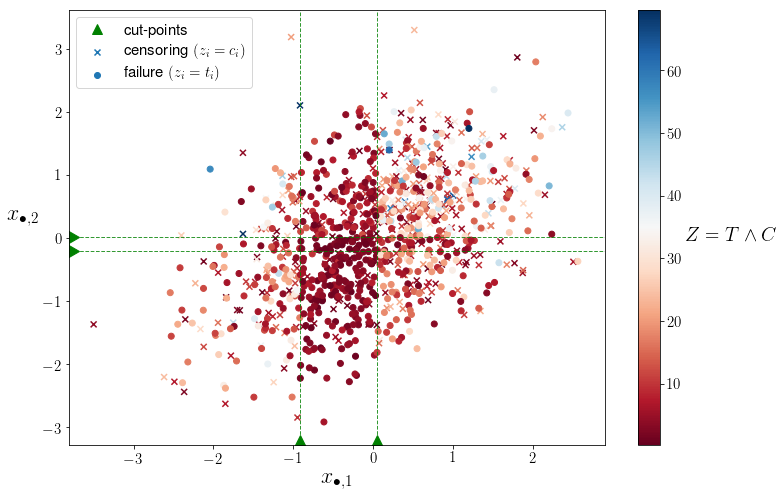

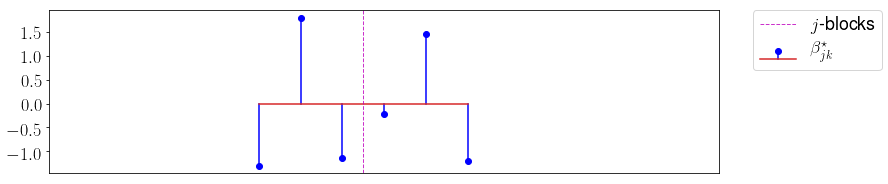

In [34]:
if n_features == 2:
    fig = pl.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    pl.scatter(*X[delta == 0].T, c=Y[delta == 0], cmap='RdBu', 
               marker="x", label=r"censoring $(z_i = c_i)$")
    pl.scatter(*X[delta == 1].T, c=Y[delta == 1], cmap='RdBu', 
               marker="o", label=r"failure $(z_i = t_i)$")
    cb = pl.colorbar()
    cb.ax.tick_params(labelsize=15)
    cb.set_label(r'$Z = T \wedge C$', rotation=0, fontsize=20)
    cb.ax.get_yaxis().labelpad = 50

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    ax.plot(cut_points['0'][1:-1], np.repeat(y_min, n_cut_points), 
            'g^', ms=20, label='cut-points')
    for cut_p in cut_points['0'][1:-1]:
        ax.axvline(cut_p, ls='--', c='g', alpha=.8, lw=1)
    x_min, x_max = ax.get_xlim()
    ax.set_xlim([x_min, x_max])
    ax.plot(np.repeat(x_min, n_cut_points), cut_points['1'][1:-1],
            marker=(3, 0, 3*90), c='g', ms=20)
    for cut_p in cut_points['1'][1:-1]:
        ax.axhline(cut_p, ls='--', c='g', alpha=.8, lw=1)

    ax.tick_params(labelsize=15)
    pl.tick_params(axis='x', which='both', top='off')
    ax.set_xlabel(r'$x_{\bullet, 1}$', fontsize=22)
    ax.set_ylabel(r'$x_{\bullet, 2}$', fontsize=22, rotation=0)
    ax.get_yaxis().labelpad = 20
    legend = pl.legend(prop={'size': 15})
    legend.legendHandles[0]._legmarker.set_markersize(10)
    pl.show()

fig = pl.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.stem(beta_star, 'b', markerfmt='bo', label=r"$\beta^\star_{jk}$")
ax.set_xlim([-5, len(beta_star) + 5])
n_coeffs_cum = 0
for i in range(n_features - 1):
    n_coeffs = len(cut_points[str(i)]) - 1
    label = ''
    if i == 0:
        label = r'$j$-blocks'
    ax.axvline(n_coeffs_cum + n_coeffs - .5, c='m', 
               ls='--', alpha=.8, lw=1, label=label) 
    n_coeffs_cum += n_coeffs
    
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
ax.yaxis.labelpad = 20 
ax.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0., 
          numpoints=1, markerscale=.5, fontsize=18)
pl.show()

### Split data into training and test sets

In [35]:
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
        
    X_test = X[test_index]
    Y_test = Y[test_index]
    delta_test = delta[test_index]
    
    X = X[train_index]
    Y = Y[train_index]
    delta = delta[train_index]

print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


### Binarize features

In [36]:
tic = time()
n_cuts = 50
binarizer = FeaturesBinarizer(n_cuts=n_cuts)
X_bin = binarizer.fit_transform(X)
X_bin_test = binarizer.transform(X_test)
tac = time()
print("Done binarizing in %.2e seconds." % (tac - tic))

blocks_start = binarizer.blocks_start
blocks_length = binarizer.blocks_length
boundaries = binarizer.boundaries

Done binarizing in 7.20e-03 seconds.


### Cross-validation

In [37]:
solver = 'agd'
learner = CoxRegression(penalty='binarsity', tol=1e-5,
                        solver=solver, verbose=False, 
                        max_iter=100, step=0.3,
                        blocks_start=blocks_start,
                        blocks_length=blocks_length,
                        warm_start=True)
learner._solver_obj.linesearch = False

n_folds = 10
grid_size = 20
grid_C = np.logspace(1, 3, grid_size)
scores_cv = pd.DataFrame(columns=['ll_test', 'test_std'])

tic = time()
for i, C in enumerate(grid_C):
    stdout.write("\rCV: %d%%" % ((i + 1) * 100 / grid_size))
    stdout.flush()
    scores_cv.loc[i] = compute_score(learner, X, X_bin, Y, delta, blocks_start, 
                                     blocks_length, boundaries, C, n_folds)
tac = time()
idx_min = scores_cv.ll_test.argmin()
C_best = grid_C[idx_min]

idx_chosen = min([i for i, j in enumerate(list(scores_cv.ll_test <= scores_cv.ll_test.min() 
                                               + scores_cv.test_std[idx_min])) if j])
C_chosen = grid_C[idx_chosen]

print("\nDone cross-validating in %.2e seconds." % (tac - tic))
print("C_chosen = %.1f" % C_chosen)

CV: 100%
Done cross-validating in 1.69e+00 seconds.
C_chosen = 26.4


### Learning curves

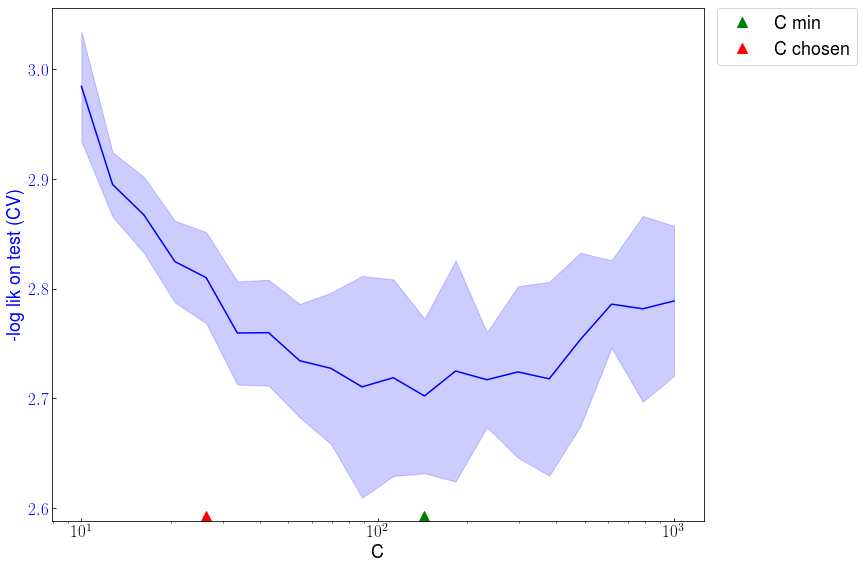

In [38]:
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

def color_y_axis(ax, color):
    for t in ax.get_yticklabels():
        t.set_color(color)

eps = scores_cv.test_std / np.sqrt(n_folds) * 1.96
pl.plot(grid_C, scores_cv.ll_test, color='b', label='')
pl.fill_between(grid_C, 
                scores_cv.ll_test - eps, 
                scores_cv.ll_test + eps, 
                color='b', alpha=0.2)
color_y_axis(ax, 'b')
ax.set_ylabel('-log lik on test (CV)', fontsize=18, color='b')

ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max])
ax.plot(C_best, y_min, 'g^', ms=20, label='C min')
ax.plot(C_chosen, y_min, 'r^', ms=20, label='C chosen')
ax.legend(bbox_to_anchor=(1.02, 1), loc=2,borderaxespad=0., 
          numpoints=1, markerscale=.5, fontsize=18)
ax.set_xlabel('C', fontsize=18)
pl.xscale('log')
pl.tight_layout()
pl.show()

## Final estimation

In [39]:
learner.C = C_chosen
learner.fit(X_bin, Y, delta)
coeffs = learner.coeffs

all_groups = list()
cut_points_estimates = {}
b_star = np.zeros(len(coeffs))

for i, start in enumerate(blocks_start):
    coeffs_ = coeffs[start:start + blocks_length[i]]
    
    all_zeros = not np.any(coeffs_)
    if all_zeros:
        cut_points_estimate = np.array([-np.inf, np.inf])
    else:
        coeffs_ = np.array([np.arange(len(coeffs_)), coeffs_]).T
        bgm = BGM(n_components=8, covariance_type='full', n_init=5)
        bgm.fit(coeffs_)
        groups = bgm.predict(coeffs_)        
        jump = np.where(groups[1:] - groups[:-1] != 0)[0] + 1

        if len(jump) == 0:
            cut_points_estimate = np.array([-np.inf, np.inf])
        else:
            cut_points_estimate = boundaries[str(i)][jump]
            if cut_points_estimate[0] != -np.inf:
                cut_points_estimate = np.insert(cut_points_estimate, 0,
                                                -np.inf)
            if cut_points_estimate[-1] != np.inf:
                cut_points_estimate = np.append(cut_points_estimate,
                                                np.inf)
    cut_points_estimates[str(i)] = cut_points_estimate  
    if i > 0:
        groups += len(jump) + 1
    all_groups += list(groups)
    
binarizer = FeaturesBinarizer(method='given',
                              bins_boundaries=cut_points_estimates)
X_bin = binarizer.fit_transform(X)
X_bin_test = binarizer.transform(X_test)

learner = CoxRegression(tol=1e-5, solver=solver, verbose=False, 
                        penalty='none', max_iter=100)

learner.fit(X_bin, Y, delta)
final_coeffs = learner.coeffs

### Visualization of the $\hat \beta$ clustering to denoise jumps detection

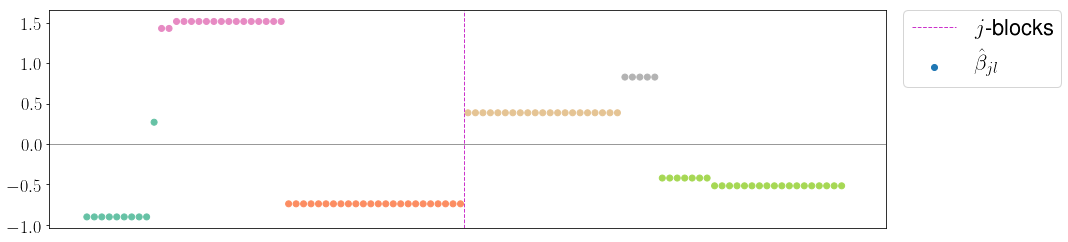

In [40]:
fig = pl.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.axhline(0, c='grey', alpha=.8, lw=1)
pl.scatter(range(len(coeffs)), coeffs, c=all_groups, 
           cmap='Set2', label=r"$\hat \beta_{jl}$")
ax.set_xlim([-5, len(coeffs) + 5])
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')

for i, val in enumerate(blocks_start[1:]):
    label = ''
    if i == 0:
        label = r'$j$-blocks'
    ax.axvline(val - .5, c='m', ls='--', alpha=.8, 
               lw=1, label=label)

pl.yticks(fontsize = 18)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, fontsize=22)
pl.show()

### Get $b^\star$ and $\widehat{\beta^\star}$

In [41]:
right_translations, block_separation = [], []
b_star_x, b_star_y = [], []
hat_beta_star_x, hat_beta_star_y = [], []
K_star, hat_K_star = np.array([]), np.array([])
previous_max, start, start_ = 0, 0, 0
mu, mu_star, hat_mu_star = np.array([]), np.array([]), np.array([])
for j in range(n_features):
    mu_jk = boundaries[str(j)].copy()[1:-1]    
    current_min = np.min(mu_jk)
    right_translation = previous_max
    if(j > 0):
        right_translation += abs(current_min)
    right_translations += [right_translation]
    mu_jk += right_translation
    mu = np.append(mu, mu_jk)
    
    mu_star_j = cut_points[str(j)][1:-1] + right_translation
    mu_star = np.append(mu_star, mu_star_j)
    K_star_j = len(mu_star_j)
    K_star = np.append(K_star, K_star_j)
    beta_star_j = beta_star[start:start + K_star_j + 1]
    start += K_star_j + 1
    b_star_x += [current_min if j==0 else previous_max]
    b_star_y += [beta_star_j[0]]
    for k in range(K_star_j):
        l_star_jk = np.argmax(np.where(mu_jk <= mu_star_j[k])) + 1
        b_star_x += [mu_jk[l_star_jk]]
        b_star_y += [beta_star_j[k + 1]]
    
    hat_mu_star_j = cut_points_estimates[str(j)][1:-1] + right_translation
    hat_mu_star = np.append(hat_mu_star, hat_mu_star_j)
    hat_K_star_j = len(hat_mu_star_j)
    hat_K_star = np.append(hat_K_star, hat_K_star_j)
    hat_beta_star_j = final_coeffs[start_:start_ + hat_K_star_j + 1]
    start_ += hat_K_star_j + 1
    hat_beta_star_x += [current_min if j==0 else previous_max]
    hat_beta_star_y += [hat_beta_star_j[0]]
    for k in range(hat_K_star_j):
        hat_l_jk = np.argmax(np.where(mu_jk <= hat_mu_star_j[k]))
        hat_beta_star_x += [mu_jk[hat_l_jk]]
        hat_beta_star_y += [hat_beta_star_j[k + 1]]
    
    previous_max = np.max(mu)
    block_separation += [previous_max]

b_star_x += [previous_max]
b_star_y = [b_star_y[0]] + b_star_y
hat_beta_star_x += [previous_max]
hat_beta_star_y = [hat_beta_star_y[0]] + hat_beta_star_y

## Auto cutoff method

In [42]:
tic = time()
p_values_auto_cutoff = auto_cutoff(X, boundaries, Y, delta)
tac = time()
print("\nDone estimating with auto_cutoff method in %.2e seconds." % (tac - tic))


Done estimating with auto_cutoff method in 1.99e+01 seconds.


## Lausen & Schumacher Correction

In [43]:
tic = time()
for j in range(n_features):
    p_values_j = p_values_auto_cutoff[j]
    p_value = p_value_cut(p_values_j.p_values, p_values_j.values_to_test, X[:, j])
    print("p_value_corrected: %.2e\n" % p_value)
tac = time()
print("\nDone Lausen & Schumacher correction in %.2e seconds." % (tac - tic))

p_value_corrected: 1.86e-29

p_value_corrected: 8.70e-20


Done Lausen & Schumacher correction in 2.28e-02 seconds.


### Estimation metrics

1) estimation of the number of cut-points: $m_1 = \frac 1 p \sum_j |\widehat{K^\star_j} - K^\star_j|$  
2) estimation of the cut-points values:  
Denoting $\mathcal{U}^\star_j = \{\mu^\star_{j,1}, \ldots, \mu^\star_{j,K^\star_j} \}$ and $\widehat{\mathcal{U}^\star_j} = \{\widehat{\mu^\star_{j,1}}, \ldots, \widehat{\mu^\star_{j,\widehat{K^\star_j}}} \}$,  
$m_2 = \frac 1 p \sum_j \mathcal{H}(\mathcal{U}^\star_j, \widehat{\mathcal{U}^\star_j})$ 
where $\mathcal{H}(A, B)$ is the Hausdorff distance between the two sets $A$ and $B$, namely 
$\mathcal{H}(A, B) = \sup[\mathcal{E}(A \| B);\mathcal{E}(B \| A )]$ 
and $\mathcal{E}(A \| B) = \sup_{b\in B} \inf_{a \in A}|a - b|$

## Final comparison

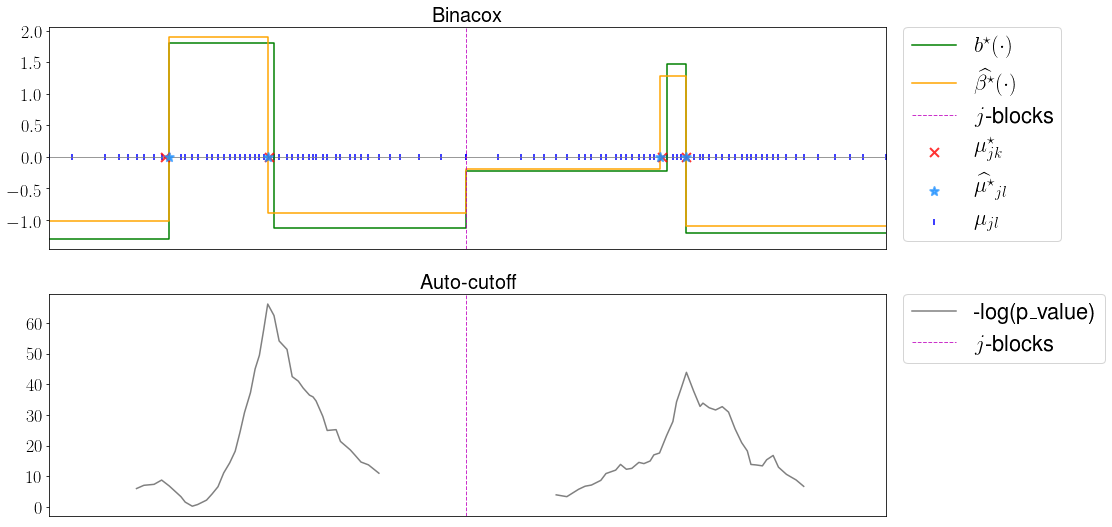

m_1 = 0.00
m_2 = 3.00e-02


In [46]:
fig = pl.figure(figsize=(15, 9))
ax = fig.add_subplot(211)
ax.axhline(0, c='grey', alpha=.8, lw=1)
pl.step(b_star_x, b_star_y, c='g', label=r"$b^\star(\cdot)$")
pl.step(hat_beta_star_x, hat_beta_star_y, c='orange', 
        label=r"$\widehat{\beta^\star}(\cdot)$")

pl.scatter(mu_star, np.zeros(len(mu_star)), c='r', marker='x',
           s=80, lw=2, label=r"$\mu^\star_{jk}$", zorder=5, alpha=.8)
pl.scatter(hat_mu_star, np.zeros(len(hat_mu_star)), c='dodgerblue', marker='*',
           s=80, lw=2, label=r"$\widehat{\mu^\star}_{jl}$", zorder=6, alpha=.7)
pl.scatter(mu, np.zeros(len(mu)), c='b', marker="|",
          label=r"$\mu_{jl}$")
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
for j in range(n_features):
    label = ''
    if j == 0:
        label = r'$j$-blocks'
    ax.axvline(block_separation[j], c='m', ls='--', 
               alpha=.8, lw=1, label=label)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, fontsize=22)
pl.title("Binacox", fontsize=20)
x_min, x_max = ax.get_xlim()
ax.set_xlim([b_star_x[0], b_star_x[-1]])
    
ax = fig.add_subplot(212)
ax.set_xlim([b_star_x[0], b_star_x[-1]])
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
pl.title("Auto-cutoff", fontsize=20)

for j in range(n_features):
    p_values_j = p_values_auto_cutoff[j]
    label = ''
    if j == 0:
        label = "-log(p\_value)"
    ax.plot(p_values_j.values_to_test + right_translations[j], -np.log(p_values_j.p_values), 
            c='grey', label=label)    
    if j == 0:
        label = r'$j$-blocks'
    ax.axvline(block_separation[j], c='m', ls='--', 
               alpha=.8, lw=1, label=label)

ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, fontsize=22)
pl.show()

m_1 = get_m_1(hat_K_star, K_star, n_features)
m_2 = get_m_2(cut_points_estimates, cut_points)

print("m_1 = %.2f" % m_1)
print("m_2 = %.2e" % m_2)